# Audio Data Augmentation

In [1]:
#Export
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *

In [2]:
#Export
import matplotlib.pyplot as plt
import torch
from fastai import *
from fastai.text import * 
from fastai.vision import *
import torch
import librosa
import torchaudio
from torchaudio import transforms

## Sample Data: Free ST American English Corpus

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

In [3]:
from fastai.basics import url2name, datapath4file, untar_data
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
path = datapath4file(url2name(data_url))
untar_data(data_url, dest = path) 
good_sample = path.ls()[256] # arbitrary choice of file

In [4]:
ex = AudioData.load(good_sample)
display(AudioItem(ex))

AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

### Make a CUDA version of an example

We shouldn't need to do this - next step is to work out why the AudioData tensors aren't being created as CUDA tensors by default. But for now, we'll do it the hard way, and make sure A) that all the transforms will work regardless of device and B) see if there's a substantial perf difference.

In [5]:
def cudaify(ai):
    return AudioData(ai.sig.cuda(), ai.sr)

In [6]:
cex = cudaify(ex)
print(cex.sig.device)
display(AudioItem(cex))

cuda:0


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

## Helper functions

In [7]:
#Export
def show_in_out(s:AudioData, r:AudioData):
    """Helper to plot input and output signal in different colors"""
    if s is not None: plt.plot(s.sig, 'm', label="Orig.")
    if r is not None: plt.plot(r.sig, 'c', alpha=0.5, label="Transf.")
    plt.legend()
    plt.show()

In [8]:
#Export
def tfm_tester(testSignal:AudioData, tfm, **kwargs):
    #TODO: track performance of execution
    tfms = listify(tfm)
    ret = testSignal # default pass
    for t in tfms:
        ret = t(ret, **kwargs)
    print("↓ Original ↓")
    display(AudioItem(testSignal))
    print("↓ Transformed ↓")
    display(AudioItem(ret))
    show_in_out(testSignal, ret)

# Augmentation Functions

## White Noise

In [9]:
#Export
def tfm_add_white_noise(ad:AudioData, noise_scl=0.005, **kwargs)->AudioData:
    noise = torch.randn_like(ad.sig) * noise_scl
    return AudioData(ad.sig + noise, ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

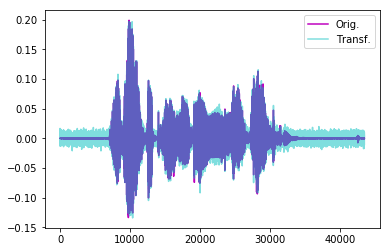

In [10]:
tfm_tester(ex, tfm_add_white_noise)

## Volume Change

In [11]:
#Export
def tfm_modulate_volume(ad:AudioData, lower_gain=.1, upper_gain=1.2, **kwargs)->AudioData:
    modulation = random.uniform(lower_gain, upper_gain)
    return AudioData(ad.sig * modulation, ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

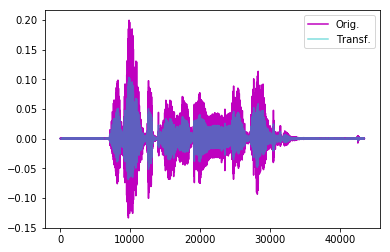

In [12]:
tfm_tester(ex, tfm_modulate_volume)

## Random Cutout

In [13]:
#Export
def tfm_random_cutout(ad:AudioData, pct_to_cut=.15, **kwargs)->AudioData:
    """Randomly replaces `pct_to_cut` of signal with silence. Similar to grainy radio."""
    copy = ad.sig.clone()
    mask = (torch.rand_like(copy)>pct_to_cut).float()
    masked = copy * mask
    return AudioData(masked,ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

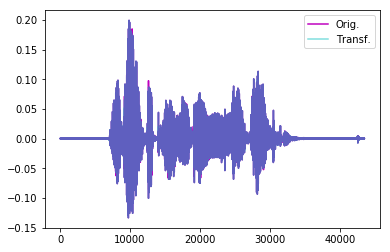

In [14]:
tfm_tester(ex, partial(tfm_random_cutout,pct_to_cut=.15))

## Pad with Silence

In [15]:
#Export
def tfm_pad_with_silence(ad:AudioData, pct_to_pad=.15, min_to_pad=None, max_to_pad=None, **kwargs)->AudioData:
    """Adds silence to beginning or end of signal, simulating microphone cut at start of end of audio."""
    if max_to_pad is None: max_to_pad = int(ad.sig.shape[0] * 0.15)
    if min_to_pad is None: min_to_pad = -max_to_pad
    pad = random.randint(min_to_pad, max_to_pad)
    copy = ad.sig.clone()
    if pad >= 0: copy[0:pad] = 0
    else: copy[pad:] = 0
    return AudioData(copy,ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

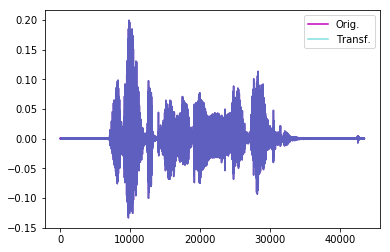

In [16]:
tfm_tester(ex, partial(tfm_pad_with_silence,pct_to_pad=.5))

## Pitch Warp

In [17]:
#Export
def tfm_pitch_warp(ad:AudioData, shift_by_pitch=None, bins_per_octave=12, **kwargs)->AudioData:
    """CAUTION - slow!"""
    min_len = 600 # librosa requires a signal of length at least 500
    copy = ad.sig.clone()
    if (copy.shape[0] < min_len): copy = torch.cat((copy, torch.zeros(min_len - copy.shape[0])))
    if shift_by_pitch is None: shift_by_pitch = random.uniform(-3, 3)
    sig = torch.tensor(librosa.effects.pitch_shift(np.array(copy), ad.sr, shift_by_pitch, bins_per_octave))
    return AudioData(sig,ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

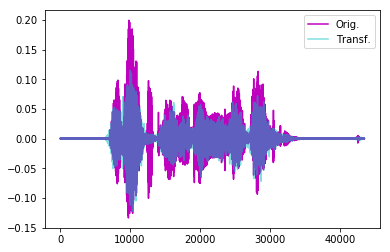

In [18]:
tfm_tester(ex, partial(tfm_pitch_warp, shift_by_pitch=10))

## Lossy Downsample and Upsample

In [19]:
#Export
def tfm_down_and_up(ad:AudioData, sr_divisor=2, **kwargs)->AudioData:
    """CAUTION - slow!"""
    copy = np.array(ad.sig.clone())
    down = librosa.audio.resample(copy, ad.sr, ad.sr/sr_divisor)
    sig = torch.tensor(librosa.audio.resample(down, ad.sr/sr_divisor, ad.sr))
    return AudioData(sig,ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

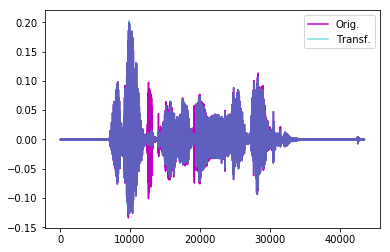

In [20]:
tfm_tester(ex, tfm_down_and_up)

## Signal Mixup

In [21]:
#Export
def tfm_signal_mixup(signal, **kwargs):
    pass

## Combined Augmentations

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

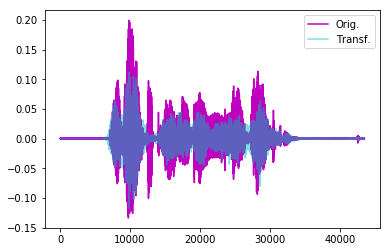

In [22]:
tfm_tester(ex, [tfm_down_and_up, tfm_pitch_warp, tfm_pad_with_silence])

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

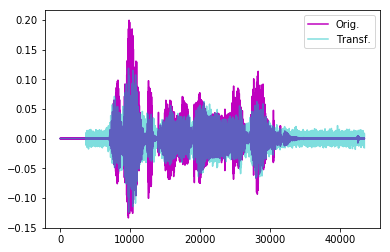

In [23]:
tfm_tester(ex, [tfm_modulate_volume, tfm_pitch_warp, tfm_add_white_noise, tfm_pad_with_silence])

In [24]:
# Other stuff to possibly explore
# AudioSegment(…).overlay()
# AudioSegment(…).apply_gain(gain)
# AudioSegment(…).invert_phase()
# AudioSegment(…).set_sample_width()

# Generic Transforms

### Pad to maximum value (resize)

In [25]:
#Export
def tfm_pad_to_max(ad:AudioData, mx=1000):
    """Pad tensor with zeros (silence) until it reaches length `mx`"""
    copy = ad.sig.clone()
    padded = torchaudio.transforms.PadTrim(max_len=mx)(copy[None,:]).squeeze()
    return AudioData(padded, ad.sr)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 0.0625sec (1000 @ 16000hz).

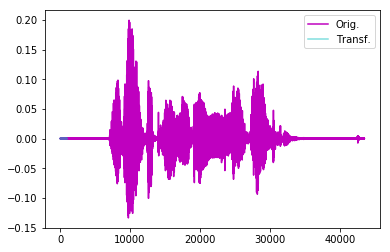

In [26]:
tfm_tester(ex, tfm_pad_to_max)

↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 31.25sec (500000 @ 16000hz).

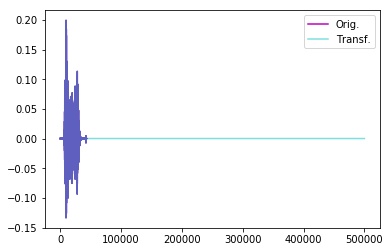

In [27]:
tfm_tester(ex, partial(tfm_pad_to_max, mx=500000))

### Log input type and properties

In [28]:
#Export
def tfm_log(x, show=False, logOnlyFirst=True, msg=''):
    '''Fake transformation that logs x shape'''
    #TODO: implements the optional "show" and "logOnlyFirst"
    if isinstance(x,AudioData): print(f'{msg}{type(x).__name__} >> Shape of signal: {x.sig.shape}  sr: {x.sr}')
    elif hasattr(x,'shape'): print(f'{msg}{type(x).__name__} >> Shape: {x.shape}')
    else: print(f'{msg}{type(x).__name__}')
    return x

AudioData >> Shape of signal: torch.Size([43520])  sr: 16000
↓ Original ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

↓ Transformed ↓


AudioItem AudioItem: 2.72sec (43520 @ 16000hz).

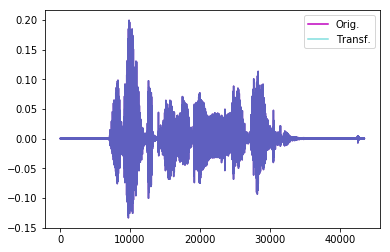

In [29]:
tfm_tester(ex, tfm_log)

## External functions

### Amplitude to db
Librosa has a function that transforms a signal from amplitude to deciblel/db scale (amplitude_to_db).
Torchaudio seems to have the same functionality (SPEC2DB) but that functionality is not documented and not accessible for current torchaudio installatio.
Probably it will be added in the next version of the library (SPEC2DB is called by MEL2).
The following code is taken from the official torchaudio docs:
https://pytorch.org/audio/_modules/torchaudio/transforms.html

In [30]:
#Export

from torch.autograd import Variable

def _check_is_variable(tensor):
    if isinstance(tensor, torch.Tensor):
        is_variable = False
        tensor = Variable(tensor, requires_grad=False)
    elif isinstance(tensor, Variable):
        is_variable = True
    else:
        raise TypeError("tensor should be a Variable or Tensor, but is {}".format(type(tensor)))

    return tensor, is_variable

class SPEC2DB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.

    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is -80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        self.top_db = -top_db if top_db > 0 else top_db
        self.multiplier = 10. if stype == "power" else 20.

    def __call__(self, spec):

        spec, is_variable = _check_is_variable(spec)
        spec_db = self.multiplier * torch.log10(spec / spec.max())  # power -> dB
        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new([self.top_db]))
        return spec_db if is_variable else spec_db.data

## Formatting Transforms

In [1]:
#Export
def tfm_extract_signal(ad:AudioData, **kwargs):
    return ad.sig

NameError: name 'AudioData' is not defined

In [32]:
#Export
def tfm_spectro(ad:AudioData, sr=16000, to_db_scale=False, n_fft=400, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128, **kwargs):
    # We must reshape signal for torchaudio to generate the spectrogram.
    # Note we don't pass **kwargs to stop interference from other params in the tfms.
    mel = transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels, n_fft=n_fft, ws=ws, hop=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension...
    if to_db_scale: mel = SPEC2DB(stype='magnitude', top_db=f_max)(mel)
    return mel

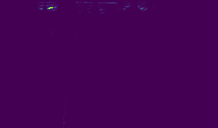

torch.Size([1, 128, 218])

In [33]:
# Default values
img = Image(tfm_spectro(ex))
display(img, img.shape)

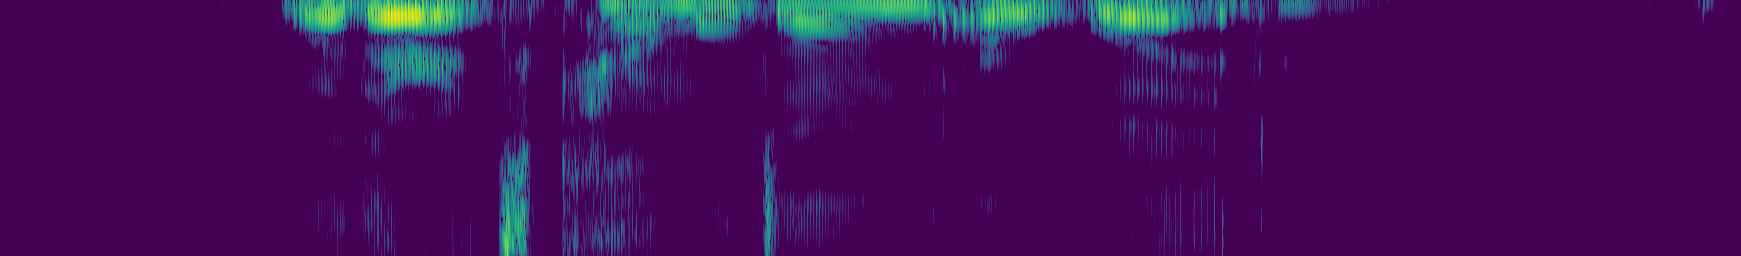

torch.Size([1, 256, 1741])

In [34]:
#Testing different values
img = Image(tfm_spectro(ex, n_mels=256, ws=50, n_fft=2048, to_db_scale=True,))
display(img, img.shape)

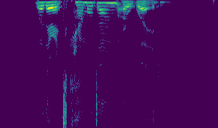

torch.Size([1, 128, 218])

In [35]:
img = Image(tfm_spectro(ex, n_mels=128, to_db_scale=True))
display(img, img.shape)

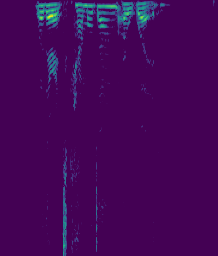

torch.Size([1, 256, 218])

In [36]:
img=tfm_spectro(ex, n_mels=256, to_db_scale=True)
display(Image(img),img.shape)

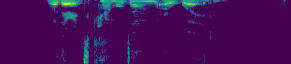

torch.Size([1, 64, 291])

In [37]:
img=tfm_spectro(ex, n_mels=64, ws=300, n_fft=1024, to_db_scale=True)
display(Image(img),img.shape)

In [38]:
#Export
def tfm_spectro_stft(ad:AudioData, n_mels=128, n_fft=480, hop_length=160, win_length=480, window='hamming', **kwargs):
    #https://www.kaggle.com/haqishen/augmentation-methods-for-audio
    #https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    stft = librosa.stft(np.array(ad.sig), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    ret = torch.tensor(stft_magnitude_db)
    ret = ret.unsqueeze(0)
    return ret

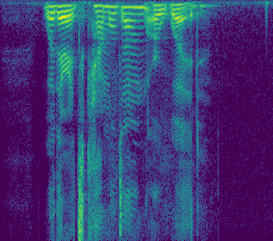

In [39]:
display(Image(tfm_spectro_stft(ex)))

## Performance

### Transformations performance

In [40]:
%timeit -n100 tfm_modulate_volume(ex)

17.9 µs ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit -n100 tfm_modulate_volume(cex)

18.1 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%timeit -n100 tfm_pad_with_silence(ex)

23.6 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%timeit -n100 tfm_pad_with_silence(cex)

40.1 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%timeit -n100 tfm_add_white_noise(ex)

414 µs ± 8.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
%timeit -n100 tfm_add_white_noise(cex)

50.6 µs ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%timeit -n100 tfm_random_cutout(ex)

536 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%timeit -n100 tfm_random_cutout(cex)

67.2 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%timeit -n100 tfm_pad_to_max(ex, mx=50000)

122 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
# %timeit -n10 tfm_down_and_up(example)

In [50]:
%timeit -n10 tfm_pitch_warp(ex)

62.8 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%timeit -n10 tfm_pitch_warp(cex)

69.8 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**VERDICT:**

Slow transformations are:
+ tfm_pitch_warp
+ tfm_down_and_up

### Spectrogram performance

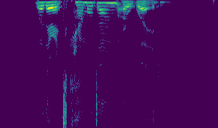

211 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
def getSpectroInDb_torchaudio(example):
    mel = tfm_spectro(example, n_mels=128)
    img = SPEC2DB(stype='magnitude', top_db=-80)(mel)
    return img
display(Image(getSpectroInDb_torchaudio(ex)))

mel = tfm_spectro(ex, n_mels=128)
%timeit SPEC2DB(stype='magnitude', top_db=-80)(mel)

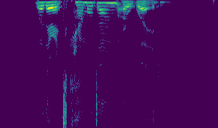

348 µs ± 8.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
def getSpectroInDb_librosa(example):
    mel = tfm_spectro(example, n_mels=128)
    img = librosa.amplitude_to_db(np.array(mel))
    img = torch.tensor(img)
    return img
display(Image(getSpectroInDb_librosa(ex)))

mel = tfm_spectro(ex, n_mels=128)
%timeit -n100 torch.tensor(librosa.amplitude_to_db(np.array(mel)))

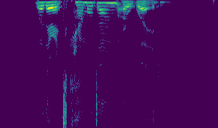

138 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
def getSpectroInDb_torchaudio_cuda(example):
    mel = tfm_spectro(example, n_mels=128)
    img = SPEC2DB(stype='magnitude', top_db=-80)(mel)
    return img
display(Image(getSpectroInDb_torchaudio_cuda(cex)))

mel = tfm_spectro(ex, n_mels=128)
mel = mel.cuda()

%timeit -n 10 SPEC2DB(stype='magnitude', top_db=-80)(mel)

**VERDICT:** 
The torchaudio on gpu is way faster than others...

# Export

In [55]:
!python notebook2script.py DataAugmentation.ipynb

Converted DataAugmentation.ipynb to nb_DataAugmentation.py
